### Librerías para ejecución del PCA con GPU

Estas celdas de código son para activar la ejecución del algoritmo PCA usando la GPU del Google Colab. Antes cuando no usábamos la GPU tardaba 45 minutos por animal en aplicar el algoritmo, pero ahora usándola tarda únicamente 2 minutos por animal.

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 300 (delta 74), reused 99 (delta 55), pack-reused 171
Receiving objects: 100% (300/300), 87.58 KiB | 2.30 MiB/s, done.
Resolving deltas: 100% (136/136), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.n

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:34
🔁 Restarting kernel...


In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
done

## Package Plan ##

 

In [ ]:
from cuml import PCA
from cuml.decomposition import PCA
import cudf

### Librerías generales

In [2]:
colab=True # Activar o desactivar si se está en google colab

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    colab = '/content/drive/MyDrive/CO-Afina-2022/'
    !pip install -r /content/drive/MyDrive/CO-Afina-2022/requirements.txt -q
else:
    colab = ''
    !pip install -r requirements.txt -q

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import json
import os
import pandas as pd
import numpy as np
from azure.storage.blob import BlobServiceClient
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2
from PIL import Image
from struct import unpack
import os
from tqdm import tqdm

### Crear dataset de train y test con las imágenes deseadas

En esta sección se itera sobre los metadatos .json (Season 1-6) buscando cuáles imágenes son realmente animales (pertenecen a las categorías 2 a la 60), y separándolos en un dataframe de train y otro de test. De igual forma no se tienen en cuenta las imágenes cuya categoría es nula, los cuales corresponden al 76% de imágenes del dataset.

In [ ]:
image_id_list_train=[]
category_id_list_train=[]
category_names_list_train=[]

image_id_list_test=[]
category_id_list_test=[]
category_names_list_test=[]

animal_images_df_train=pd.DataFrame(columns=['image_id','category_id','category_name'])

animal_images_df_test=pd.DataFrame(columns=['image_id','category_id','category_name'])
for k in range(1,7):
  # Opening JSON file
  f = open(colab+"metadata/SnapshotSerengetiS0"+str(k)+".json")
  # returns JSON object as
  # a dictionary
  data = json.load(f)
  category_id_list2=[]

  for i in tqdm(range(len(data['annotations']))):
    value = data['annotations'][i].get('category_id')
    if value != None:
        value =  int(value)
        category_name=data['categories'][value].get('name')
        contador=category_id_list2.count(value)
        if contador >= 305:
          continue
        if 2 <= value <= 60: # Only animals (categories from 2 to 60)
          image_id=data['annotations'][i].get('image_id')
          if 300 <= contador < 305:
            image_id_list_test.append(image_id)
            category_id_list_test.append(value)
            category_names_list_test.append(category_name)
          else:
            image_id_list_train.append(image_id)
            category_id_list_train.append(value)
            category_names_list_train.append(category_name)
          category_id_list2.append(value)
  
  # Closing file
  f.close()

animal_images_df_train['image_id']=image_id_list_train
animal_images_df_train['category_id']=category_id_list_train
animal_images_df_train['category_name']=category_names_list_train

animal_images_df_test['image_id']=image_id_list_test
animal_images_df_test['category_id']=category_id_list_test
animal_images_df_test['category_name']=category_names_list_test

Se eliminan los animales cuya cantidad de imágenes encontrada en los metadatos sea menor al máximo encontrado. Así nos aseguramos de que todas las clases de animales estén balanceadas cuando se haga el entrenamiento, y que también cada animal tenga una buena cantidad de imágenes y la red neuronal pueda predecir de mejor manera.

In [ ]:
cantidad_animales=animal_images_df_train.groupby('category_name').size()
animales_eliminar=[]
for i in range(len(cantidad_animales)):
    if cantidad_animales[i] != max(cantidad_animales):
        animales_eliminar.append(cantidad_animales.index[i])
        
animal_df_train_filtered=animal_images_df_train[~animal_images_df_train['category_name'].isin(animales_eliminar)]
animal_df_test_filtered=animal_images_df_test[~animal_images_df_test['category_name'].isin(animales_eliminar)]

In [ ]:
animal_df_train_filtered.reset_index(inplace=True,drop=True)
animal_df_test_filtered.reset_index(inplace=True,drop=True)

animal_df_train_filtered.to_csv(colab+'data/animal_df_train.csv',index=False)
animal_df_test_filtered.to_csv(colab+'data/animal_df_test.csv',index=False)

In [9]:
animal_df_train_filtered = pd.read_csv(colab+'data/animal_df_train.csv')
animal_df_test_filtered = pd.read_csv(colab+'data/animal_df_test.csv')

A continuación vemos el resultado de cuáles animales y cuántas imágenes se van a usar, tanto en su dataframe de train como el de test. En el caso del train se usarán 1800 imágenes por cada animal, y en el test 30 por cada animal. De igual forma, en total se usarán 18 tipos de animales (debido a que estos son los que tenían suficiente cantidad para entrenar de mejor manera la red neuronal).

**NOTA:** Esta cantidad es antes de eliminar las imágenes corruptas posteriormente.

In [ ]:
animal_df_train_filtered.groupby('category_name').size()

category_name
baboon             1800
buffalo            1800
elephant           1800
gazellegrants      1800
gazellethomsons    1800
giraffe            1800
guineafowl         1800
hartebeest         1800
hippopotamus       1800
hyenaspotted       1800
impala             1800
lionfemale         1800
otherbird          1800
reedbuck           1800
topi               1800
warthog            1800
wildebeest         1800
zebra              1800
dtype: int64

In [ ]:
animal_df_test_filtered.groupby('category_name').size()

category_name
baboon             30
buffalo            30
elephant           30
gazellegrants      30
gazellethomsons    30
giraffe            30
guineafowl         30
hartebeest         30
hippopotamus       30
hyenaspotted       30
impala             30
lionfemale         30
otherbird          30
reedbuck           30
topi               30
warthog            30
wildebeest         30
zebra              30
dtype: int64

### Descargar imágenes desde el Azure Blob Storage

Función para descargar las imágenes desde el dataset https://lila.science/datasets/snapshot-serengeti usando el Azure Blob Storage. Dichas imágenes se encuentran alojadas en la nube de Azure y gracias a ello podemos usar funciones de las librerías que Azure tiene en Python.

In [ ]:
connect_str = "DefaultEndpointsProtocol=https;AccountName=lilablobssc;EndpointSuffix=core.windows.net"

def download_blob(animal_images_df, path):
    service = BlobServiceClient.from_connection_string(connect_str)
    category_list = []
    for i in tqdm(range(len(animal_images_df))):
        image = animal_images_df['image_id'][i]
        file_name = image + '.JPG'
        container_img = "snapshotserengeti-unzipped"
        blob_client = service.get_blob_client(container=container_img, blob=file_name)

        #To download the data
        local_path =  os.getcwd()
        category_name = animal_images_df['category_name'][i]
        category_list.append(category_name)
        final_path = local_path + colab + "/images/" + path+category_name + "/" 
        final_image_path = final_path + str(category_list.count(category_name)) + '.JPG'
        #print(final_path)
        isExist = os.path.exists(final_path)
        if not isExist:
          os.makedirs(final_path) # create results directory
        try:
          with open(final_image_path, "wb") as download_data:
            download_data.write(blob_client.download_blob().readall())
        except: 
            # La imagen no existe en el Azure Blob Storage
            category_list.remove(category_name)
            animal_images_df.drop(index=i,inplace=True)
          #print("El archivo "+file_name+ " no existe en el Azure blob" )
            continue
    return animal_images_df

In [ ]:
animal_df_train_real=download_blob(animal_df_train_filtered, "train/") # Download train images from Azure Blob Storage

100%|██████████| 32400/32400 [58:43<00:00,  9.19it/s]


In [ ]:
animal_df_test_real=download_blob(animal_df_test_filtered, "test/") # Download test images from Azure Blob Storage

100%|██████████| 540/540 [00:40<00:00, 13.28it/s]


In [ ]:
# Imágenes de test que sí fueron descargadas (debido a que hay algunas imágenes que sí están en el metadata pero no en el Azure Blob Storage)
animal_df_test_real.to_csv(colab+'data/animal_df_test_real.csv',index=False)

### Eliminar imágenes corruptas

Algunas imágenes JPG del dataset están corruptas, y no pueden ser usadas para el entrenamiento. En esta función las eliminamos para que el entrenamiento de la red neuronal se pueda hacer sin problemas.

In [ ]:
# Eliminar imágenes corruptas
# Extraído de https://github.com/tensorflow/tpu/issues/455
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                raise TypeError("issue reading jpeg file")       

nombre_clases = animal_df_train_filtered.sort_values('category_name')['category_name'].unique()
for i in range(len(nombre_clases)):                
    bads = []
    img_dir=colab+'images/train/'+ nombre_clases[i]
    root_img=colab+'images/train/'+ nombre_clases[i]

    for dirName, subdirList, fileList in os.walk(img_dir):
        imagesList = fileList
        for img in tqdm(imagesList):
          image = os.path.join(root_img,img)
          image = JPEG(image)
          try:
            image.decode()   
          except:
            bads.append(img)


    for name in bads:
      os.remove(os.path.join(root_img,name))

100%|██████████| 110/110 [00:02<00:00, 50.28it/s]


## Modelo sin PCA

Sección con la red neuronal la cual recibe las imágenes sin aplicarles PCA

### Tratamiento y visualización de datos

In [ ]:
dir_train = colab+"images/train" 
dir_test = colab+"images/test" 

In [ ]:
clases = os.listdir(dir_train)
num_clases = len(clases)
num_clases

18

In [ ]:
# Vamos a hacerle un resize a las imágenes, para que queden de 224x224 y sea más rapido el entrenamiento
batch_size = 32
img_height = 224
img_width = 224
input_shape = (224, 224, 3)

Como vemos a continuación, luego de la eliminación de imágenes corruptas nos quedamos con 2408 para training entre todos los 18 animales.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(dir_train,
                                                      validation_split=0.1,
                                                      subset="training",
                                                      seed=123,
                                                      image_size=(img_height, img_width),
                                                      batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(dir_test,
                                                      validation_split=0.1,
                                                      subset="validation",
                                                      seed=123,
                                                      image_size=(img_height, img_width),
                                                      batch_size=batch_size)

Found 2675 files belonging to 18 classes.
Using 2408 files for training.
Found 1077 files belonging to 18 classes.
Using 107 files for validation.


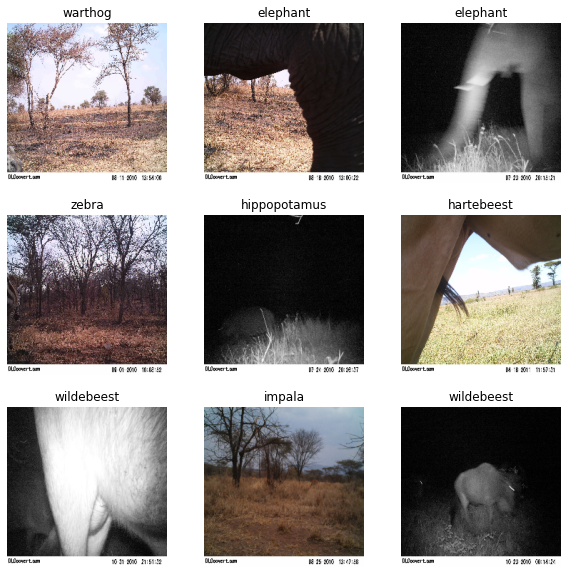

In [ ]:
import matplotlib.pyplot as plt

nombre_clases = animal_df_train_filtered.sort_values('category_name')['category_name'].unique()
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(nombre_clases[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creación de la red neuronal convolucional

In [ ]:
num_classes = len(nombre_clases)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

### Entrenamiento de la red neuronal

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
75/76 [============================>.] - ETA: 0s - loss: 2.7191 - accuracy: 0.1860

InvalidArgumentError: ignored

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save(colab+'models/model_sinPCA.h5')

### Resultados al predecir nuevos datos

In [ ]:
model = tf.keras.models.load_model('models/model_sinPCA.h5')

In [ ]:
animal_test_path=colab+'images/test/topi/3.JPG'

img = tf.keras.utils.load_img(
    animal_test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

tabla_confianza=pd.DataFrame(columns=['animal','porcentaje_confianza'])

tabla_confianza['animal']=nombre_clases
tabla_confianza['porcentaje_confianza']=100*score
tabla_confianza['porcentaje_confianza']=[round(num,3) for num in tabla_confianza['porcentaje_confianza']]
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(nombre_clases[np.argmax(score)], 100 * np.max(score))
)
tabla_confianza.sort_values('porcentaje_confianza',ascending=False)

This image most likely belongs to topi with a 98.06 percent confidence.


,animal,porcentaje_confianza
19,topi,98.059
20,warthog,0.526
16,ostrich,0.525
10,hartebeest,0.208
13,impala,0.148
5,elephant,0.096
6,gazellegrants,0.093
1,buffalo,0.079
8,giraffe,0.073
9,guineafowl,0.069


### Mejorar accuracy

Para mejorar el accuracy volvemos a entrenar el mismo modelo, aplicando un EarlyStopping para que la red deje de entrenarse si no nota mejoría en el error, y de igual forma usando el ReduceLROnPlateau el cual reduce el learning rate cuando nota que el accuracy no está mejorando.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                           patience=3, 
                           mode='auto',
                           restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1, 
                              patience=2, 
                              verbose=1, 
                              mode='auto')
history =  model.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=10,
                      callbacks=[early_stop, reduce_lr]
                      )

Epoch 1/10
86/86 [==============================] - 3s 38ms/step - loss: 0.0883 - accuracy: 0.9804 - val_loss: 9.4907 - val_accuracy: 0.1131 - lr: 0.0010
Epoch 2/10
86/86 [==============================] - 3s 33ms/step - loss: 0.0727 - accuracy: 0.9855 - val_loss: 8.7371 - val_accuracy: 0.0985 - lr: 0.0010
Epoch 3/10
85/86 [============================>.] - ETA: 0s - loss: 0.0709 - accuracy: 0.9879
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
86/86 [==============================] - 3s 31ms/step - loss: 0.0733 - accuracy: 0.9876 - val_loss: 7.8459 - val_accuracy: 0.1022 - lr: 0.0010
Epoch 4/10
86/86 [==============================] - 3s 32ms/step - loss: 0.0366 - accuracy: 0.9924 - val_loss: 8.4515 - val_accuracy: 0.0985 - lr: 1.0000e-04


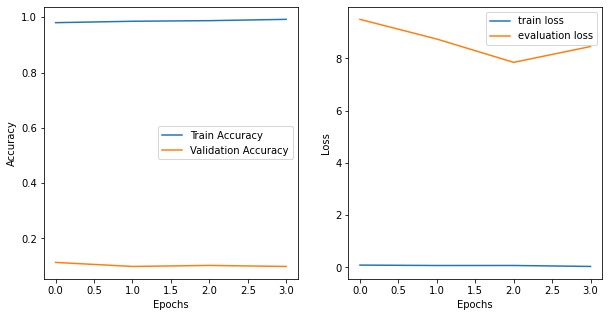

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

In [ ]:
animal_test_path=colab+'images/test/topi/5.JPG'

img = tf.keras.utils.load_img(
    animal_test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

tabla_confianza=pd.DataFrame(columns=['animal','porcentaje_confianza'])

tabla_confianza['animal']=nombre_clases
tabla_confianza['porcentaje_confianza']=100*score
tabla_confianza['porcentaje_confianza']=[round(num,3) for num in tabla_confianza['porcentaje_confianza']]
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(nombre_clases[np.argmax(score)], 100 * np.max(score))
)
tabla_confianza.sort_values('porcentaje_confianza',ascending=False)

This image most likely belongs to topi with a 50.85 percent confidence.


,animal,porcentaje_confianza
19,topi,50.850
5,elephant,26.545
10,hartebeest,13.379
16,ostrich,2.701
13,impala,2.334
8,giraffe,2.165
0,baboon,0.584
15,lionfemale,0.510
20,warthog,0.264
6,gazellegrants,0.190


In [ ]:
model.save('models/model_sinPCA_opt.h5')

## Modelo aplicando PCA - 250 componentes

Modelo con PCA usando sus 250 componentes principales

### Aplicar PCA a todas las imágenes de train

In [ ]:
# Con GPU
nombre_clases = animal_df_train_filtered.sort_values('category_name')['category_name'].unique()
for i in range(len(nombre_clases)):                
    bads = []
    img_dir=colab+'images/train/'+ nombre_clases[i]
    root_img=colab+'images/train/'+ nombre_clases[i]
    pca_img=colab+'images/pca/pca250/train/'+ nombre_clases[i]
    isExist = os.path.exists(pca_img)
    if not isExist:
        os.makedirs(pca_img) # create results directory
    for dirName, subdirList, fileList in os.walk(img_dir):
        imagesList = fileList
        for img in tqdm(imagesList):
            image = os.path.join(root_img,img)
            img_read = cv2.imread(image)

            # Splitting the image in R,G,B arrays.
            blue,green,red = cv2.split(img_read) 
            #it will split the original image into Blue, Green and Red arrays.  
            #initialize PCA with first 20 principal components
            pca = PCA(n_components=250) # map the data to 4 dimensions

            #Applying to red channel and then applying inverse transform to transformed array.
            red_transformed = pca.fit(red.astype(np.float32))
            red_transformed2 = pca.transform(red.astype(np.float32))
            red_inverted = pca.inverse_transform(red_transformed2)

            #Applying to Green channel and then applying inverse transform to transformed array.
            green_transformed = pca.fit(green.astype(np.float32))
            green_transformed2 = pca.transform(green.astype(np.float32))
            green_inverted = pca.inverse_transform(green_transformed2)

            #Applying to Blue channel and then applying inverse transform to transformed array.
            blue_transformed = pca.fit(blue.astype(np.float32))
            blue_transformed2 = pca.transform(blue.astype(np.float32))
            blue_inverted = pca.inverse_transform(blue_transformed2)

            img_compressed = (np.dstack((red_inverted, green_inverted, blue_inverted))).astype(np.uint8)
            
            img2 = Image.fromarray(img_compressed, 'RGB')
            img2.save(pca_img+'/'+img)
            
            #cv2.imwrite(pca_img+'/'+img, img_compressed) 
        

100%|██████████| 110/110 [01:24<00:00,  1.30it/s]


### Tratamiento y visualización de datos

In [4]:
dir_train = colab+"images/pca/pca250/train" 
dir_test = colab+"images/test" 

In [5]:
clases = os.listdir(dir_train)
num_clases = len(clases)
num_clases

18

In [6]:
# Vamos a hacerle un resize a las imágenes, para que queden de 224x224 y sea más rapido el entrenamiento
batch_size = 32
img_height = 224
img_width = 224
input_shape = (224, 224, 3)

Como vemos a continuación, luego de la eliminación de imágenes corruptas nos quedamos con 2408 para training entre todos los 18 animales.

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(dir_train,
                                                      validation_split=0.1,
                                                      subset="training",
                                                      seed=123,
                                                      image_size=(img_height, img_width),
                                                      batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(dir_test,
                                                      validation_split=0.1,
                                                      subset="validation",
                                                      seed=123,
                                                      image_size=(img_height, img_width),
                                                      batch_size=batch_size)

Found 2675 files belonging to 18 classes.
Using 2408 files for training.
Found 1077 files belonging to 18 classes.
Using 107 files for validation.


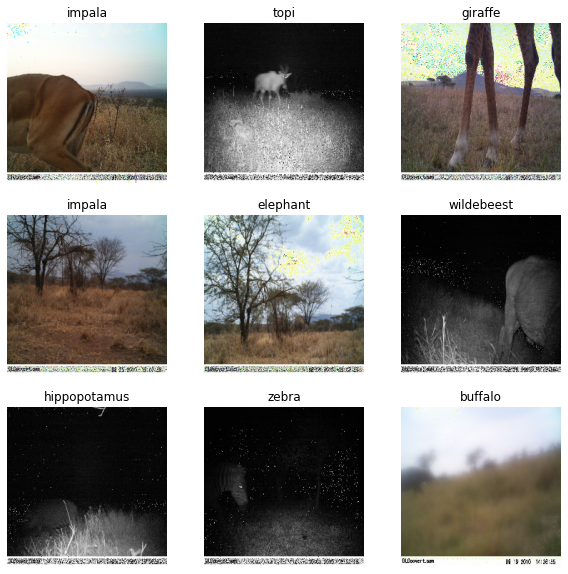

In [10]:
import matplotlib.pyplot as plt
nombre_clases = animal_df_train_filtered.sort_values('category_name')['category_name'].unique()
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(nombre_clases[labels[i]])
    plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creación de la red neuronal convolucional

In [12]:
num_classes = len(nombre_clases)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

### Entrenamiento de la red neuronal

In [15]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


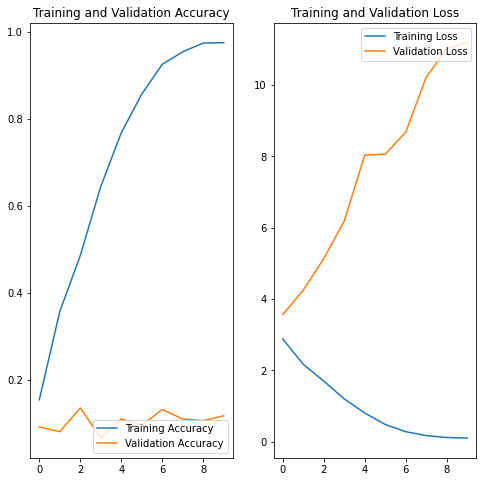

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save(colab+'models/model_conPCA250.h5')

### Resultados al predecir nuevos datos

In [ ]:
model = tf.keras.models.load_model(colab+'models/model_conPCA250.h5')

In [ ]:
animal_test_path=colab+'images/test/topi/5.JPG'

img = tf.keras.utils.load_img(
    animal_test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

tabla_confianza=pd.DataFrame(columns=['animal','porcentaje_confianza'])

tabla_confianza['animal']=nombre_clases
tabla_confianza['porcentaje_confianza']=100*score
tabla_confianza['porcentaje_confianza']=[round(num,3) for num in tabla_confianza['porcentaje_confianza']]
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(nombre_clases[np.argmax(score)], 100 * np.max(score))
)
tabla_confianza.sort_values('porcentaje_confianza',ascending=False)

This image most likely belongs to cheetah with a 38.60 percent confidence.


,animal,porcentaje_confianza
2,cheetah,38.599
1,buffalo,38.480
20,warthog,11.784
5,elephant,6.780
6,gazellegrants,3.106
15,lionfemale,0.635
13,impala,0.536
14,koribustard,0.033
10,hartebeest,0.027
17,otherbird,0.010


### Mejorar accuracy

Para mejorar el accuracy volvemos a entrenar el mismo modelo, aplicando un EarlyStopping para que la red deje de entrenarse si no nota mejoría en el error, y de igual forma usando el ReduceLROnPlateau el cual reduce el learning rate cuando nota que el accuracy no está mejorando.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                           patience=3, 
                           mode='auto',
                           restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1, 
                              patience=2, 
                              verbose=1, 
                              mode='auto')
history =  model.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=10,
                      callbacks=[early_stop, reduce_lr]
                      )

Epoch 1/10
73/73 [==============================] - 3s 35ms/step - loss: 0.0719 - accuracy: 0.9842 - val_loss: 11.6394 - val_accuracy: 0.1241 - lr: 0.0010
Epoch 2/10
73/73 [==============================] - 2s 32ms/step - loss: 0.0708 - accuracy: 0.9837 - val_loss: 12.1695 - val_accuracy: 0.1241 - lr: 0.0010
Epoch 3/10
73/73 [==============================] - 3s 41ms/step - loss: 0.0831 - accuracy: 0.9846 - val_loss: 12.2353 - val_accuracy: 0.1460 - lr: 0.0010
Epoch 4/10
73/73 [==============================] - 3s 36ms/step - loss: 0.0406 - accuracy: 0.9923 - val_loss: 11.8128 - val_accuracy: 0.1350 - lr: 0.0010
Epoch 5/10
73/73 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9867
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
73/73 [==============================] - 2s 31ms/step - loss: 0.0634 - accuracy: 0.9867 - val_loss: 11.2005 - val_accuracy: 0.1314 - lr: 0.0010
Epoch 6/10
73/73 [==============================] - 2s 32ms/step 

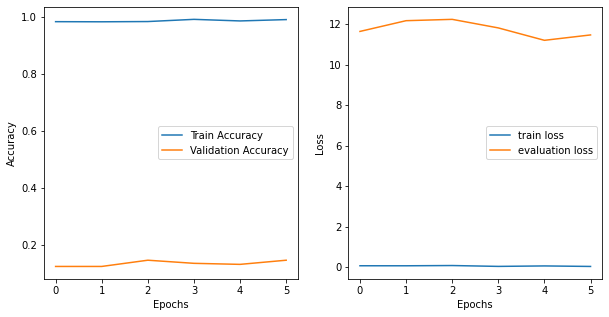

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

In [ ]:
model.save(colab+'models/model_conPCA250_opt.h5')

In [ ]:
animal_test_path=colab+'images/test/cheetah/1.JPG'

img = tf.keras.utils.load_img(
    animal_test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

tabla_confianza=pd.DataFrame(columns=['animal','porcentaje_confianza'])

tabla_confianza['animal']=nombre_clases
tabla_confianza['porcentaje_confianza']=100*score
tabla_confianza['porcentaje_confianza']=[round(num,3) for num in tabla_confianza['porcentaje_confianza']]
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(nombre_clases[np.argmax(score)], 100 * np.max(score))
)
tabla_confianza.sort_values('porcentaje_confianza',ascending=False)

This image most likely belongs to cheetah with a 77.27 percent confidence.


,animal,porcentaje_confianza
2,cheetah,77.269
20,warthog,21.795
1,buffalo,0.670
6,gazellegrants,0.209
15,lionfemale,0.047
13,impala,0.007
10,hartebeest,0.002
21,wildebeest,0.001
0,baboon,0.000
14,koribustard,0.000
